Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from glob import glob
from keras.callbacks import ReduceLROnPlateau

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
mydict={}
for (root,dirs,files) in os.walk(data_dir_train, topdown=False):
  if len(files)>0:
    mydict[root]=len(files)
print(mydict)

{'/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma': 95, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/basal cell carcinoma': 376, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/actinic keratosis': 114, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/melanoma': 438, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/nevus': 357, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/pigmented benign keratosis': 462, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/seborrheic keratosis': 77, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/squamous cell carcinoma': 181, '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/vascular lesion': 139}


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train", labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train", labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

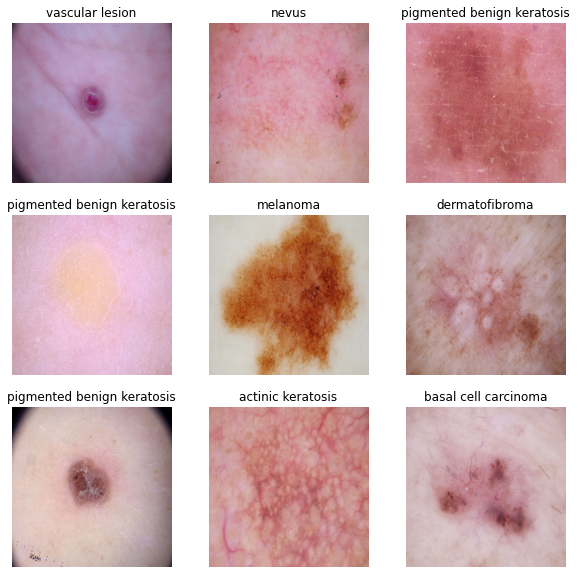

In [ ]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[labels[i]])
                plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# See learning curve and validation curve




### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#model.compile(optimizer='your_optimser',
              #loss=your_loss_function_goes_here,
              #metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 67ms/step - loss: 2.0314 - accuracy: 0.2366 - val_loss: 2.0488 - val_accuracy: 0.1566
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7998 - accuracy: 0.3577 - val_loss: 1.6349 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4757 - accuracy: 0.4994 - val_loss: 1.4392 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3425 - accuracy: 0.5285 - val_loss: 1.3703 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2561 - accuracy: 0.5508 - val_loss: 1.3518 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1978 - accuracy: 0.5938 - val_loss: 1.4802 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1337 - accuracy: 0.5971 - val_loss: 1.4910 - val_accuracy: 0.5168
Epoch 8/20
5

### Visualizing training results

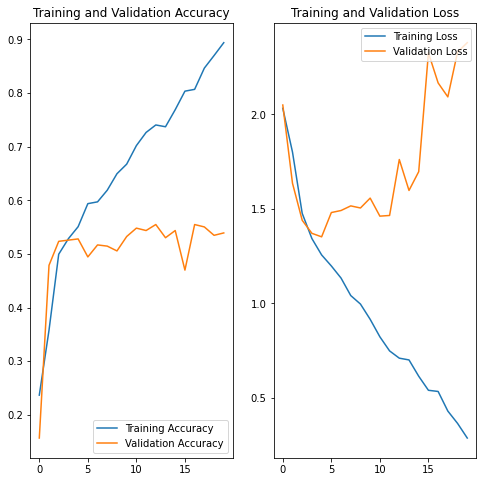

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

It is found that the model goes overfitting as the graph shows the training accuracy is very high compare to the validation accuracy

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

IMG_SIZE = 180
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

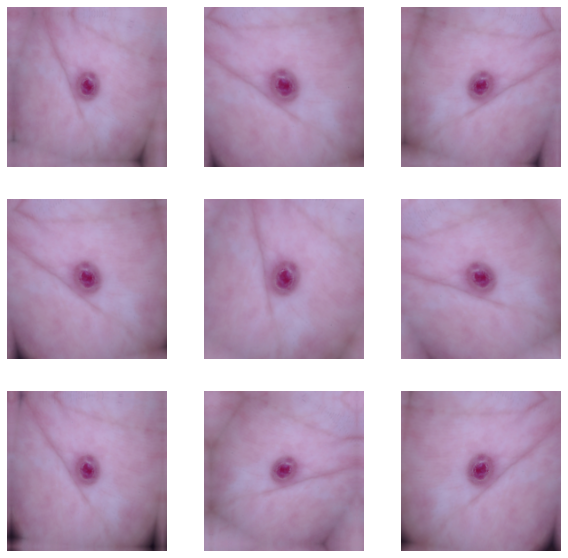

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs



#epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 2s 24ms/step - loss: 1.9851 - accuracy: 0.2868 - val_loss: 1.8579 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6585 - accuracy: 0.3962 - val_loss: 1.5914 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5258 - accuracy: 0.4565 - val_loss: 1.6256 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4280 - accuracy: 0.5106 - val_loss: 1.4121 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3880 - accuracy: 0.5117 - val_loss: 1.5298 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4060 - accuracy: 0.5006 - val_loss: 1.4512 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3022 - accuracy: 0.5301 - val_loss: 1.3184 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

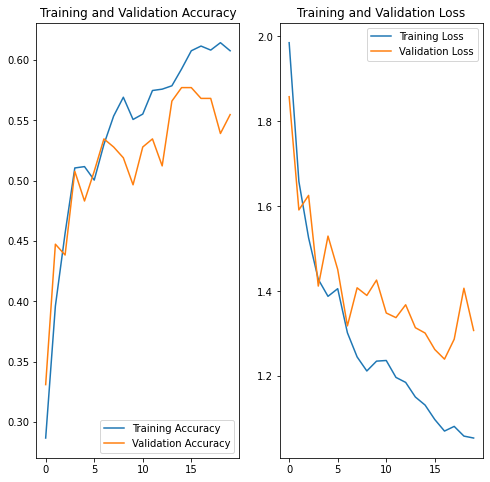

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Now after adding dropout, we see the training accuracy and validation accuracy is very close. The training accuracy has fallen as adding dropout ensures the loss of parameters hence the information.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
ListClassName=[]
NumberImage=[]

for i in class_names:

  data_dir_train_sub=pathlib.Path(str(data_dir_train)+"/"+i)
  image_count_train = len(list(data_dir_train_sub.glob('*/*.jpg')))
  ListClassName.append(i)
  NumberImage.append(image_count_train)
  #print(i,"--->",image_count_train)

df=pd.DataFrame({"Class_Name":ListClassName,
                 "Number_of_Images":NumberImage
                 })
df

,Class_Name,Number_of_Images
0,actinic keratosis,500
1,basal cell carcinoma,500
2,dermatofibroma,500
3,melanoma,500
4,nevus,500
5,pigmented benign keratosis,500
6,seborrheic keratosis,500
7,squamous cell carcinoma,500
8,vascular lesion,500


#### **Todo: Each class has different amount of samples (code is at the begining).
#### - Which class has the least number of samples?
Ans: seborrheic keratosis( 77 # Samples)
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: pigmented benign keratosis( 462 # Samples)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/"
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F25101BDC50>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


basal cell carcinoma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F25102B9A50>:   0%|          | 1/500 [00:00<01:15,  6.58 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F25D6DF1150>: 100%|██████████| 500/500 [00:19<00:00, 25.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F251029FED0>: 100%|██████████| 500/500 [00:19<00:00, 25.92 Samples/s]


melanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F25351F7050>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


nevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F25D70D3A90>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


pigmented benign keratosis


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F254415ECD0>:   0%|          | 1/500 [00:00<01:07,  7.37 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2593B435D0>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F25102FA710>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


squamous cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F253510F9D0>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F253542AF50>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026473.jpg_fb95908c-4cf8-4bb9-a125-28782494b498.jpg',
 '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_b4cbab11-e830-4cc1-8e04-a709fffe7a21.jpg',
 '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031358.jpg_68e8e99f-33d9-4f33-9089-48516c1baa19.jpg',
 '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0034135.jpg_5190b613-1a20-4620-ba2a-ec9345c9e1b9.jpg',
 '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_35fc2ad4-8efa-4964-8bce-f96f51efe17b.jpg',
 '/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train/dermatofibroma/output/dermatofibroma_o

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [ ]:
new_df['Label'].value_counts()

vascular lesion               500
nevus                         500
pigmented benign keratosis    500
squamous cell carcinoma       500
melanoma                      500
actinic keratosis             500
basal cell carcinoma          500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/z_Deep_Learning/11_ISIC_Melanoma/DataSet/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30  #(Due to some problems in colab, epochs is limited to 30 here)
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 177ms/step - loss: 1.8936 - accuracy: 0.2791 - val_loss: 1.5959 - val_accuracy: 0.3675
Epoch 2/30
169/169 [==============================] - 31s 176ms/step - loss: 1.5140 - accuracy: 0.4251 - val_loss: 1.4576 - val_accuracy: 0.4388
Epoch 3/30
169/169 [==============================] - 31s 177ms/step - loss: 1.3925 - accuracy: 0.4731 - val_loss: 1.3575 - val_accuracy: 0.4967
Epoch 4/30
169/169 [==============================] - 31s 178ms/step - loss: 1.3309 - accuracy: 0.5007 - val_loss: 1.2922 - val_accuracy: 0.5301
Epoch 5/30
169/169 [==============================] - 31s 177ms/step - loss: 1.2612 - accuracy: 0.5178 - val_loss: 1.1514 - val_accuracy: 0.5620
Epoch 6/30
169/169 [==============================] - 31s 178ms/step - loss: 1.1728 - accuracy: 0.5608 - val_loss: 1.1220 - val_accuracy: 0.5783
Epoch 7/30
169/169 [==============================] - 31s 176ms/step - loss: 1.1768 - accuracy: 0.5616 - val_loss: 1.1016 - val_ac

#### **Todo:**  Visualize the model results

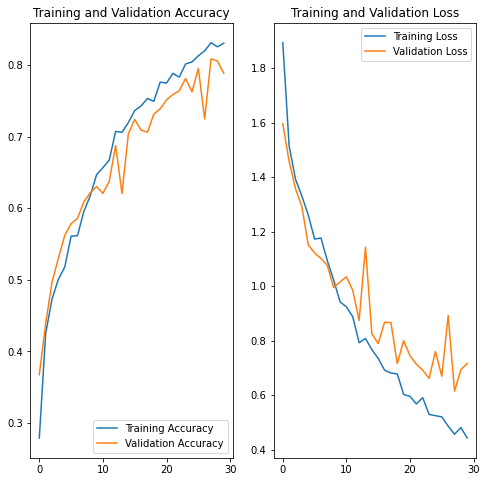

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Finally, the problem of overfitting is rectified. The rebalance helps to increase training and validation accuracy (near about 80%).